In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import svm
import seaborn as sns

In [2]:
combinedDf = pd.read_csv('../data/processed/combined.csv')

In [3]:
combinedDf.head()

,Unnamed: 0,O*NET-SOC Code,Title,Description,A_MEAN
0,11-1011,11-1011.00,Chief Executives,Determine and formulate policies and provide o...,213020
1,11-1011,11-1011.03,Chief Sustainability Officers,"Communicate and coordinate with management, sh...",213020
2,11-1021,11-1021.00,General and Operations Managers,"Plan, direct, or coordinate the operations of ...",115250
3,11-1031,11-1031.00,Legislators,"Develop, introduce, or enact laws and statutes...",57110
4,11-2011,11-2011.00,Advertising and Promotions Managers,"Plan, direct, or coordinate advertising polici...",142860


In [4]:
print(combinedDf[combinedDf['Title'] == 'Chief Executives']['Description'][0])

Determine and formulate policies and provide overall direction of companies or private and public sector organizations within guidelines set up by a board of directors or similar governing body. Plan, direct, or coordinate operational activities at the highest level of management with the help of subordinate executives and staff managers.


## Get the word features

In [5]:
count_vect = CountVectorizer(ngram_range=(1,1),min_df=0.03)

In [6]:
counts = count_vect.fit_transform(combinedDf['Description'])

In [7]:
counts

<956x110 sparse matrix of type '<class 'numpy.int64'>'
	with 9481 stored elements in Compressed Sparse Row format>

In [8]:
tf_transformer = TfidfTransformer(use_idf=False).fit(counts)

In [9]:
X_train_tf = tf_transformer.transform(counts)

In [11]:
combinedDf['A_MEAN'].isna().sum()

0

<AxesSubplot:xlabel='A_MEAN', ylabel='Density'>

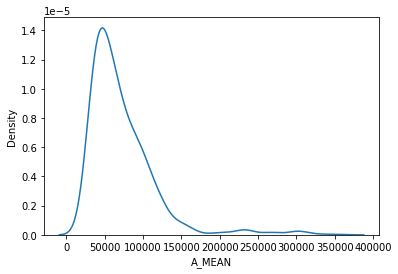

In [12]:
sns.kdeplot(combinedDf['A_MEAN'])

<AxesSubplot:xlabel='A_MEAN', ylabel='Density'>

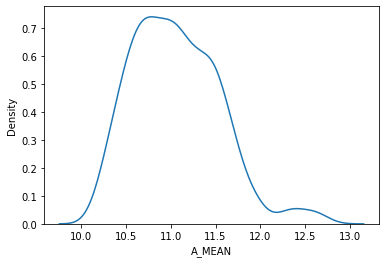

In [13]:
sns.kdeplot(np.log(combinedDf['A_MEAN']))

## Make a model

In [14]:
reg = linear_model.LinearRegression()

In [16]:
y = np.log(combinedDf['A_MEAN'])
# log scale the salaries

In [17]:
reg.fit(X_train_tf, y)

LinearRegression()

In [18]:
newJobs = ['Works with pets and lifts heavy objects','Makes decisions and manages a budget','Determine and formulate policies and provide overall direction of companies or private and public organizations within guidelines set up by a board of directors or similar governing body. Plan, direct, or coordinate operational activities at the highest level of management with the help of subordinate executives and staff managers.']

In [19]:
newJobsCounts = count_vect.transform(newJobs)

In [20]:
newJobsCounts

<3x110 sparse matrix of type '<class 'numpy.int64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [21]:
tf_transformer.transform(newJobsCounts)

<3x110 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [22]:
reg.predict(tf_transformer.transform(newJobsCounts))

array([10.96715628, 10.93193801, 11.40460725])

In [23]:
reg.score(X_train_tf,y)

0.542156881049183

## Cross Validation

In [24]:
reg = linear_model.LinearRegression()

In [25]:
scores = cross_val_score(reg, X_train_tf, y, cv=4)

In [26]:
scores

array([-2.40175407, -0.70881173, -1.34232857, -0.96499057])

## Train Test Split

In [28]:
reg = linear_model.LinearRegression()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tf, y, test_size=0.33, random_state=42)

In [30]:
reg.fit(X_train,y_train)

LinearRegression()

In [31]:
mean_absolute_error(y_test,reg.predict(X_test))

0.31863884514519064

In [32]:
abs(np.exp(reg.predict(X_test)) - np.exp(y_test)).mean()

25134.008870049413

In [ ]:
plt.plot()

In [113]:
reg.predict(X_test)

array([ 96730.08846109,  98473.04736431,  71203.30717682,  35440.38491545,
        51326.81047762,  86893.31951115,  79581.85446587,  71014.13090402,
       148107.14266903,  82681.12986006,  56360.82753947,  74961.92657404,
        44308.66202546,  60617.13886666,  87587.83229218, 103589.48783363,
       122033.54993885,  58637.44576785,  50938.90679646,  56295.59604543,
        50975.83128579,  95211.07966244,  42558.28815755,  23042.29732541,
        71568.50375352, 134465.39360567,  39815.78476938, 101478.67516539,
        42690.63284967,  95419.21435117,  46066.62183043, 111323.01736595,
        65136.66819712,  39658.91946571,  95568.17398913,  57100.02456807,
       105196.49059881,  83040.37820361,  76144.48126401,  54725.54131111,
        47832.28956388, 107509.21387656,  68503.09359046,  48202.16472674,
        71885.41735888,  65333.90254487,  53691.92611927,  86372.40658883,
        45034.38744795,  81231.98216094,  92903.14977665,  88737.24839569,
        70038.80602674,  

In [33]:
regr = svm.SVR()

In [34]:
regr.fit(X_train,y_train)

SVR()

In [35]:
mean_absolute_error(y_test,regr.predict(X_test))

0.289150758054006

## Grid Search

In [36]:
X = combinedDf['Description']
y = np.log(combinedDf['A_MEAN'])

In [51]:
y.isna().sum()

0

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [38]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("svr", svm.SVR()),
    ]
)

In [39]:
parameters = {
    "vect__max_df": (0.5, 0.75, 0,9, 1.0),
    "vect__min_df": (0.0, 0.01, 0.025, 0.05),
     'tfidf__use_idf': (True, False),
    "svr__C": (0.01,0.1,0.5,1),
    "svr__kernel" : ('linear', 'poly', 'rbf')
}

In [44]:
def my_log_loss(y_true, y_pred):
    return abs(np.exp(y_pred + 1) - np.exp(y_true + 1)).mean()

In [45]:
score = make_scorer(my_log_loss, greater_is_better=False)

In [46]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = score)

In [52]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/Users/alexisrutherford/salary_prediction/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
720 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alexisrutherford/salary_prediction/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alexisrutherford/salary_prediction/venv/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/alexisrutherford/salary_prediction/venv/lib/python3.9/site-p

GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': (0.01, 0.1, 0.5, 1),
                         'svr__kernel': ('linear', 'poly', 'rbf'),
                         'tfidf__use_idf': (True, False),
                         'vect__max_df': (0.5, 0.75, 0, 9, 1.0),
                         'vect__min_df': (0.0, 0.01, 0.025, 0.05)},
             scoring=make_scorer(my_log_loss, greater_is_better=False),
             verbose=1)

In [48]:
grid_search.best_score_

-61268.37274101919